In [1]:
#music encoding and decoding library
from music21 import *

#importing files into notebook
from pathlib import Path
import glob

#for listing down the file names
import os

#Array Processing
import numpy as np

#importing library
from collections import Counter

#Fancy progress bar
from tqdm.notebook import tqdm

#Plots
import matplotlib.pyplot as plt

#splitting data into train and test
from sklearn.model_selection import train_test_split

# Keras
import keras
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.utils import np_utils

In [2]:
#read MIDI files return notes
def read_midi(file):
#     print("Loading Music File:",file)
    # initialize     
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file - converting to music21 objects(Scores)
    midi = converter.parse(file)
  
    #separate as instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
        #Piano and Guitar elements
        if ('Piano' in str(part) or ('Guitar' in str(part))): 
            notes_to_parse = part.recurse() 
      
            #note or chord
            for element in notes_to_parse:
                
                #handling a note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #handling a chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [3]:
#folder path
folder = Path(r'metalmidi/Metal Midi/').rglob('*.mid')

#separate to each notes/chords
notes_2d = np.array([read_midi(file) for file in tqdm(folder)])    

In [4]:
#2D to 1D 
notes_1d = [ele for temp in notes_2d for ele in temp]

#length of unique notes from entire list
unique_notes = list(set(notes_1d))
print(len(unique_notes))

235


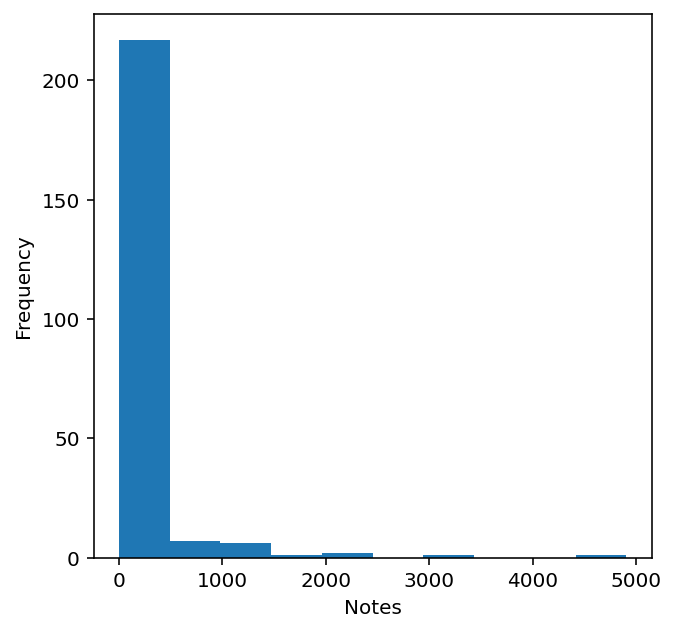

In [5]:
#frequency of each note
freq = dict(Counter(notes_1d))
n = [i for i in freq.values()]

#plots
plt.figure(figsize=(5,5))
plt.hist(n)
plt.xlabel('Notes')
plt.ylabel('Frequency')
plt.show()

In [6]:
#taking only high frequency notes by setting threshold as 20
frequent_notes = [i for i,count in freq.items() if count>=20]

In [7]:
# initializing new music array with only high frequency notes
new_music=[]
for notes in notes_2d:
    temp=[n for n in notes if n in frequent_notes]
    new_music.append(temp)      

new_music = np.array(new_music)

In [8]:
# initializing inputs and outputs as notes
n_ts = 32
x = []
y = []

for n in new_music:
    for i in range(0, len(n) - n_ts, 1):
        
        # inputs and outputs
        Input = n[i:i + n_ts]
        Output = n[i + n_ts]
        x.append(Input)
        y.append(Output)
        
x=np.array(x)
y=np.array(y)

In [9]:
# converting notes to ints
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [10]:
#input sequences for the network
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        # unique integer for every notes/chords
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [11]:
#output sequences for the network
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [12]:
# splitting data 80/20 train and val
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [13]:
#MODEL

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(512,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(16,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           23300     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 512)           154112    
_________________________________________________________________
dropout (Dropout)            (None, 32, 512)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 512)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           196736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [14]:
# Save best model after each epoch based on min val_loss 
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [15]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=75, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/75
228/229 [============================>.] - ETA: 0s - loss: 2.8478 - accuracy: 0.2996
Epoch 00001: loss improved from inf to 2.84664, saving model to best_model.h5
229/229 [==============================] - 11s 48ms/step - loss: 2.8466 - accuracy: 0.2998 - val_loss: 2.5980 - val_accuracy: 0.3554
Epoch 2/75
229/229 [==============================] - ETA: 0s - loss: 2.1895 - accuracy: 0.3600
Epoch 00002: loss improved from 2.84664 to 2.18953, saving model to best_model.h5
229/229 [==============================] - 10s 46ms/step - loss: 2.1895 - accuracy: 0.3600 - val_loss: 2.3039 - val_accuracy: 0.3762
Epoch 3/75
229/229 [==============================] - ETA: 0s - loss: 1.9851 - accuracy: 0.3862
Epoch 00003: loss improved from 2.18953 to 1.98506, saving model to best_model.h5
229/229 [==============================] - 10s 45ms/step - loss: 1.9851 - accuracy: 0.3862 - val_loss: 2.0271 - val_accuracy: 0.4071
Epoch 4/75
228/229 [============================>.] - ETA: 0s - loss: 1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


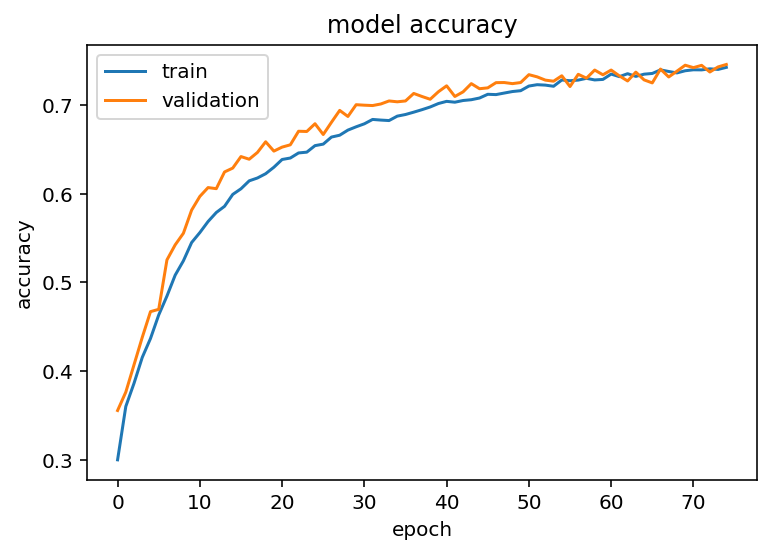

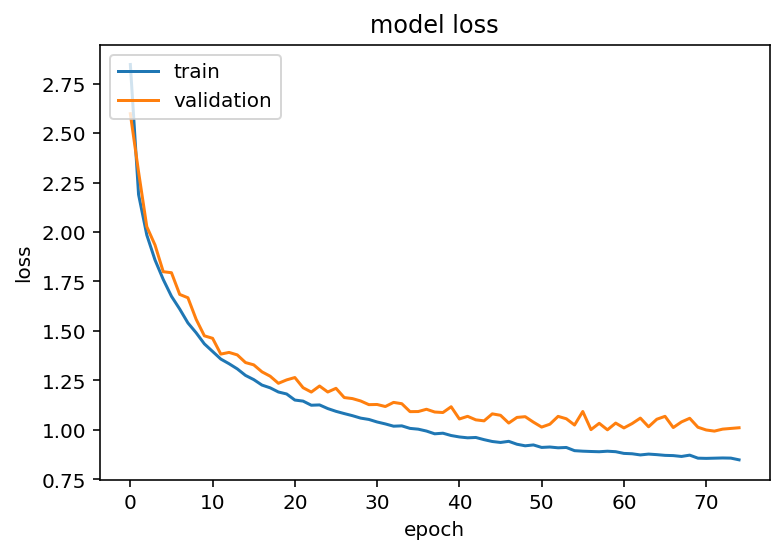

In [16]:
# plots
print(history.history.keys())
# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

In [18]:
# Prediction by using random note sequence as starting point
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(30):

    random_music = random_music.reshape(1,n_ts)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]


In [19]:
#  converting generated ints to notes to form a music file 
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [20]:
# Covert to a midi format using (piano instrument)
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [21]:
# Save file as music.mid to storage
convert_to_midi(predicted_notes)